In [19]:
import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.io import read_image
import glob

seed_job = 2021

In [4]:
from pathlib import Path
from PIL import Image
import logging
import matplotlib.pyplot as plt

In [60]:
class ImageDataset(Dataset):
    def __init__(self, 
                 img_dir: str,
                 size_img: int = 224,
                 extension: str = 'png',
                 transform=None,
                 augmentation=None):
        
        
        assert 32 <= size_img <= 2048, 'Size selection is not appropriate, pick between 32 and 2048'
        self.size_img = size_img
        
        lst_tiles = [f for f in glob.glob(img_dir + "/*." + extension)]
        lst_class = [f.split('__')[-1].split('.')[0] for f in lst_tiles]
        lst_class = [''.join(filter(lambda x: not x.isdigit(), c)) for c in lst_class]
        
        self.img_dir = lst_tiles
        self.ids = lst_class
        
        if not self.ids:
            raise RuntimeError(f'No Input Files in {img_dir}!')
        logging.info(f'Creating Dataset: {len(self.ids)} examples...')
    
    def __len__(self):
        return len(self.ids)
    
    @classmethod
    def preprocess(cls, img, size_img, mask):
        w, h = img.size
        w_sized, h_sized = size_img, size_img
        assert w_sized > 32 and h_sized > 32, 'Requesed Image Size is too small!'
        img = img.resize((w_sized, h_sized))
        img_ndarray = np.asarray(img)
        
        if img_ndarray.ndim == 2 and not mask:
            img_ndarray = img_ndarray[np.newaxis, ...]
            img_ndarray = img_ndarray / 255
        elif not mask:
            img_ndarray = img_ndarray.transpose((2, 0, 1))
            img_ndarray = img_ndarray / 255
        
        return img_ndarray
    
    @classmethod
    def loader(cls, filename: str):
        return Image.open(filename)
    
    def __getitem__(self, idx: int):
        name_cls = self.ids[idx]
        img = self.img_dir[idx]
        print(name_cls)
        img = self.loader(img)
        ann = {"Stroma":0, "normal":1, "pannet":2}[name_cls]
        
        img = self.preprocess(img, self.size_img, mask=False)
        
        return {'image': torch.as_tensor(img.copy()).float().contiguous(),
               'ann': ann}
        
        

In [61]:
PATH_IMG = "/kuacc/users/skoc21/dataset/pannet/wsi-tiles/annotated-qupath/"

In [62]:
dataset = ImageDataset(img_dir=PATH_IMG, extension='jpg')

In [63]:
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset)

In [64]:
# Display image and label.
data_dict = next(iter(dataloader))
train_features, train_labels = data_dict['image'], data_dict['ann']
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

normal
Feature batch shape: torch.Size([1, 3, 224, 224])
Labels batch shape: torch.Size([1])


## Visualize Image

In [69]:
import torchvision

Label: tensor([1])


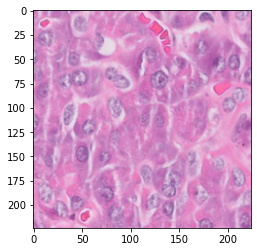

In [76]:
# ToTensor = torchvision.transforms.ToTensor()
FromTensor = torchvision.transforms.ToPILImage()
img = train_features.squeeze()
t = FromTensor(img)
plt.imshow(t) # matplotlib
print(f"Label: {train_labels}")

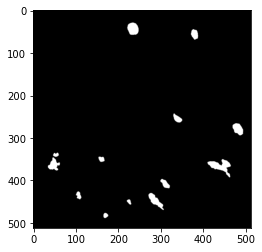

In [53]:
plt.imshow(label, cmap="gray")
plt.show()

# Create Dataset

In [68]:
PATH_DATASET = '/kuacc/users/skoc21/dataset/tumor_bud_ihc/DATASET_BUD_24_3/'
PATH_IMG = os.path.join(PATH_DATASET, 'img')

percent_val = 0.2
batch_size = 1

In [61]:
dataset = ImageDataset(PATH_IMG)

In [63]:
# Split into train and validation
n_val = int(len(dataset) * percent_val)
n_train = len(dataset) - n_val
print(f"Train Set Count: {n_train}\tVal Set Count: {n_val}")

Train Set Count: 1240	Val Set Count: 310


In [64]:
from torch.utils.data import random_split

In [66]:
data_train, data_val = random_split(dataset,
                                    lengths=[n_train, n_val],
                                    generator=torch.Generator().manual_seed(seed_job))

In [70]:
# Create data loaders
loader_args = dict(batch_size=batch_size, num_workers=2, pin_memory=True)
loader_train = DataLoader(data_train, shuffle=True, **loader_args)
loader_val = DataLoader(data_val, shuffle=False, **loader_args)